In [2]:
import pandas as pd
import os
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import datetime

from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from statistics import mean 

%matplotlib inline             
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')

In [4]:
df.columns = ['id','datetime','read_count']

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'],infer_datetime_format=True)

df.timestamp = pd.to_datetime(df['datetime'],infer_datetime_format=True) #format='%Y-%m-%d')
df.index = df.timestamp


In [6]:
df['datetime'] = pd.to_datetime(df['datetime'],infer_datetime_format=True) 
df.dtypes

id                     int64
datetime      datetime64[ns]
read_count             int64
dtype: object

In [7]:
df.head()

,id,datetime,read_count
datetime,,,
2019-07-01 00:00:00,1,2019-07-01 00:00:00,1421
2019-07-01 01:00:00,2,2019-07-01 01:00:00,1116
2019-07-01 02:00:00,3,2019-07-01 02:00:00,921
2019-07-01 03:00:00,4,2019-07-01 03:00:00,824
2019-07-01 04:00:00,5,2019-07-01 04:00:00,737


In [8]:
train = df[0:3648]
val = df[3648:]

In [9]:
train.shape, val.shape

((3648, 3), (912, 3))

Brief analysis

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3648.0,1824.500000,1053.231219,1.0,912.75,1824.5,2736.25,3648.0
read_count,3648.0,2329.609375,925.738756,572.0,1573.00,2208.0,3080.25,6074.0


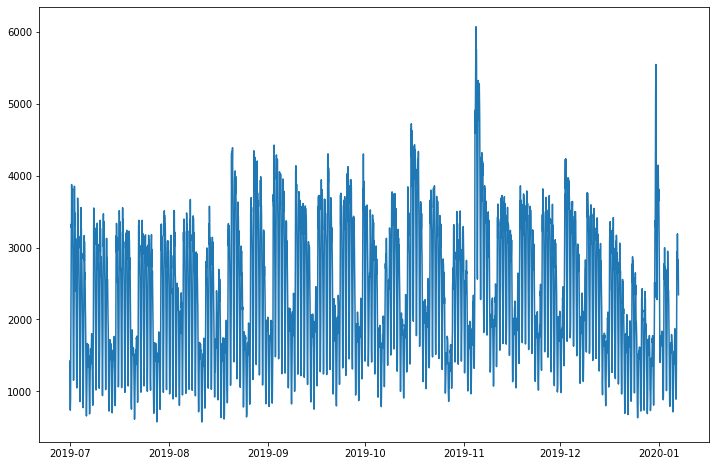

In [11]:
## plot graph

plt.figure(figsize=(12,8))

plt.plot(df.index, df['read_count'])

In [11]:
train[(train.read_count) >5000]

,id,datetime,read_count
datetime,,,
2019-11-04 15:00:00,3040,2019-11-04 15:00:00,5387
2019-11-04 16:00:00,3041,2019-11-04 16:00:00,5491
2019-11-04 17:00:00,3042,2019-11-04 17:00:00,5878
2019-11-04 18:00:00,3043,2019-11-04 18:00:00,6061
2019-11-04 19:00:00,3044,2019-11-04 19:00:00,6074
2019-11-04 20:00:00,3045,2019-11-04 20:00:00,5760
2019-11-04 21:00:00,3046,2019-11-04 21:00:00,5760
2019-11-04 22:00:00,3047,2019-11-04 22:00:00,5756
2019-11-04 23:00:00,3048,2019-11-04 23:00:00,5173


we can limit outliers later and check id it has any impact on the result

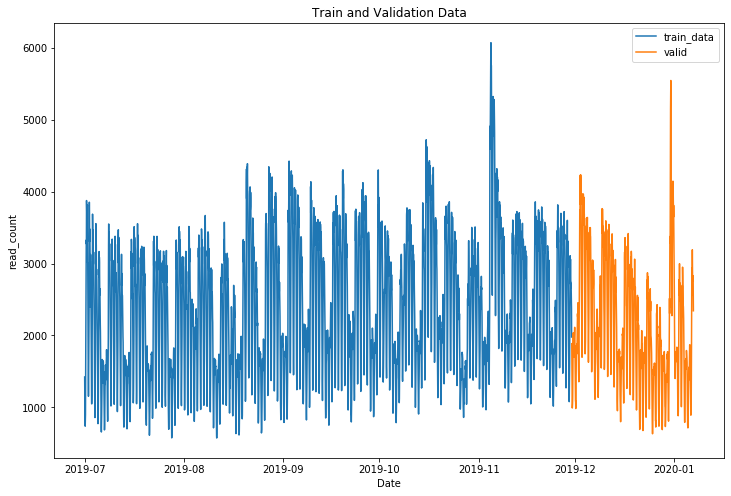

In [12]:
## plot graph

plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index,val['read_count'], label='valid')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('read_count')
plt.title("Train and Validation Data")
plt.show()

Stationarity test:

In [13]:
# dickey fuller, KPSS


In [11]:
def adf_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [12]:
adf_test(train['read_count'])

Results of Dickey-Fuller Test:
Test Statistic                -7.988959e+00
p-value                        2.504394e-12
#Lags Used                     2.900000e+01
Number of Observations Used    3.618000e+03
Critical Value (1%)           -3.432159e+00
Critical Value (5%)           -2.862339e+00
Critical Value (10%)          -2.567195e+00
dtype: float64


In [13]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [14]:
kpss_test(train['read_count'])

Results of KPSS Test:
Test Statistic            1.26053
p-value                   0.01000
Lags Used                30.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


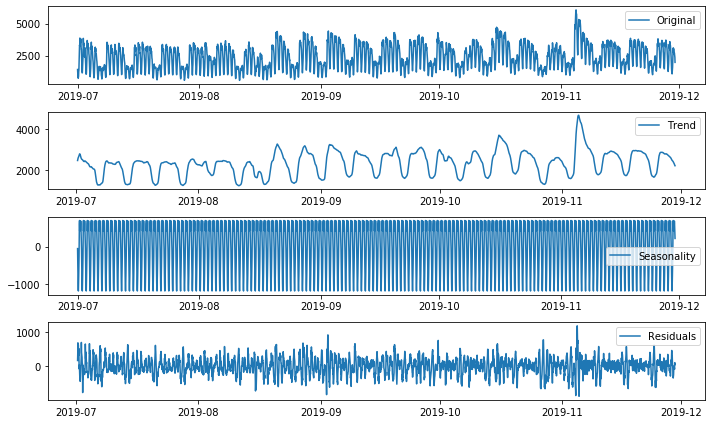

In [18]:
decomposition = seasonal_decompose(train[['read_count']]) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train['read_count'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
# test_stationarity(decomposedLogData)

Shows a weekly seasonality, to confirm let's check further

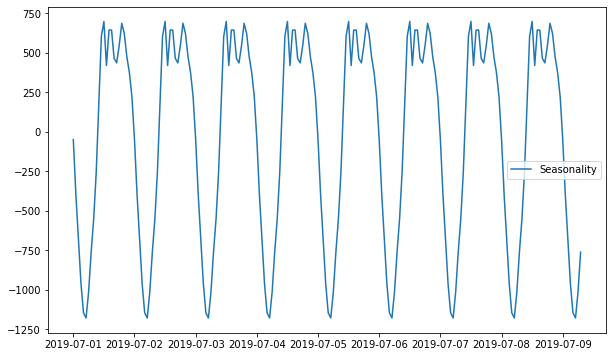

In [19]:
plt.plot(seasonal[0:200], label='Seasonality')
plt.legend(loc='best')

ACF and PACF plots:

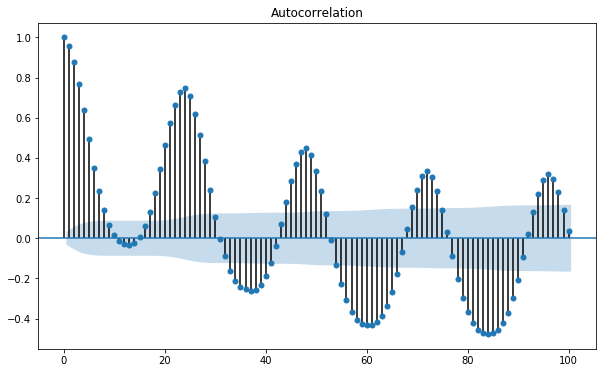

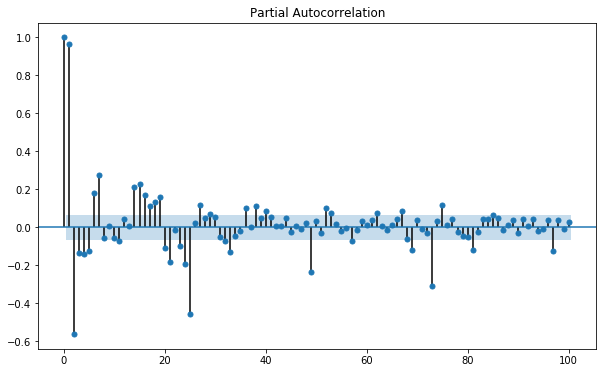

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train['read_count'].dropna(), lags=100)
plot_pacf(val['read_count'].dropna(), lags=100)
plt.show()

In [21]:
val.shape

(912, 3)

AR model:

In [22]:
# fit model
model = ARIMA(train['read_count'], order=(7,0,0))
model_fit = model.fit()

In [24]:
# gernerate forecasts
output = model_fit.forecast(912) 

val['Ar'] = (pd.DataFrame(output)).values

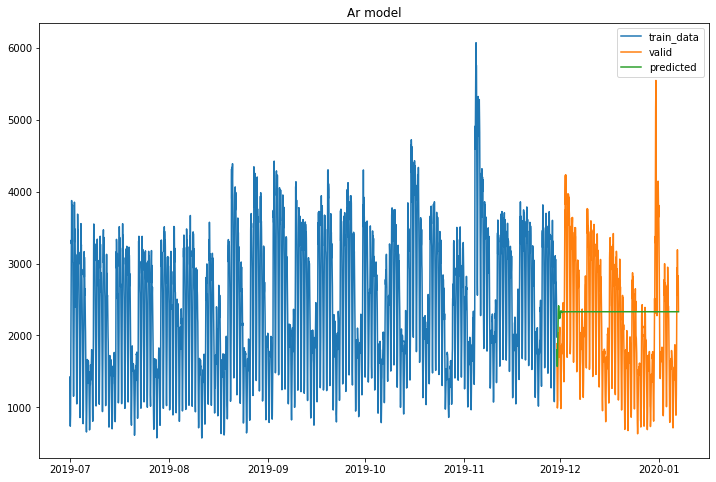

In [25]:

plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['Ar'], label='predicted')

plt.legend(loc='best')
plt.title("Ar model")
plt.show()

In [26]:
np.sqrt(mse(val['read_count'],val['Ar']))

878.0958275188849

MA model:

In [27]:
# fit model
model = ARIMA(train['read_count'].dropna(), order=(0,0,1))
model_fit = model.fit()

In [30]:
# gernerate forecasts
output = model_fit.forecast(912) 

val['MA'] = (pd.DataFrame(output)).values

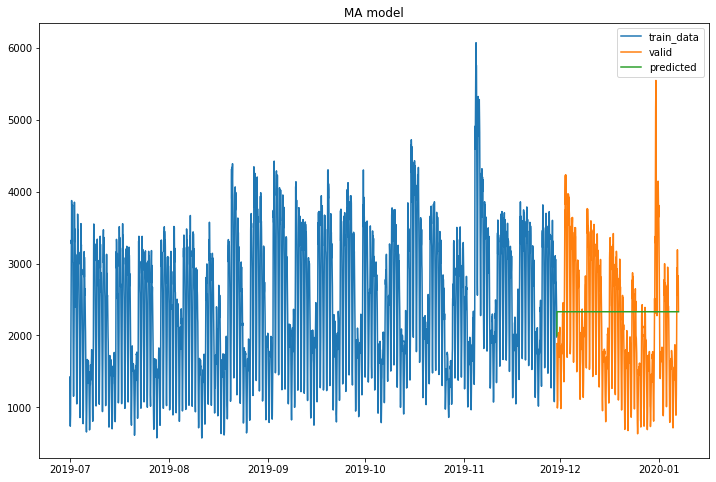

In [31]:

plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['MA'], label='predicted')

plt.legend(loc='best')
plt.title("MA model")
plt.show()

In [32]:
np.sqrt(mse(val['read_count'],val['MA']))

882.9415548355538

ARMA model:

In [33]:
# fit model
model = ARIMA(train['read_count'].dropna(), order=(7,0,8))
model_fit = model.fit()

# gernerate forecasts
output = model_fit.forecast(912) 

val['ARMA'] = (pd.DataFrame(output)).values



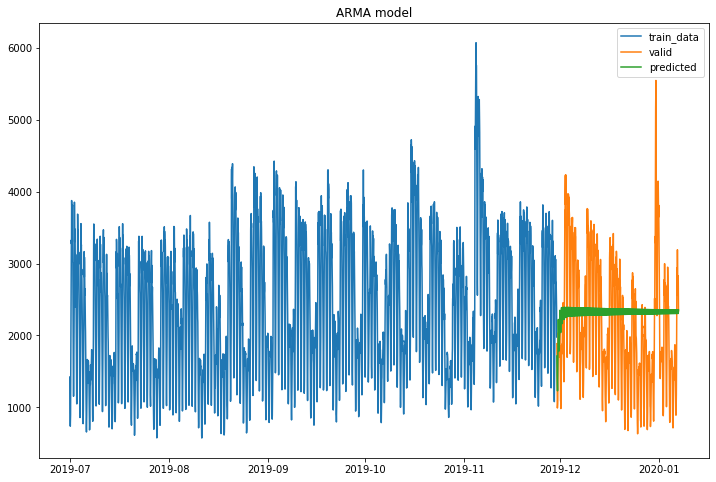

In [34]:
# plot the graph
plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['ARMA'], label='predicted')

plt.legend(loc='best')
plt.title("ARMA model")
plt.show()

In [35]:
np.sqrt(mse(val['read_count'],val['ARMA']))

872.5176329130086

ARIMA model:

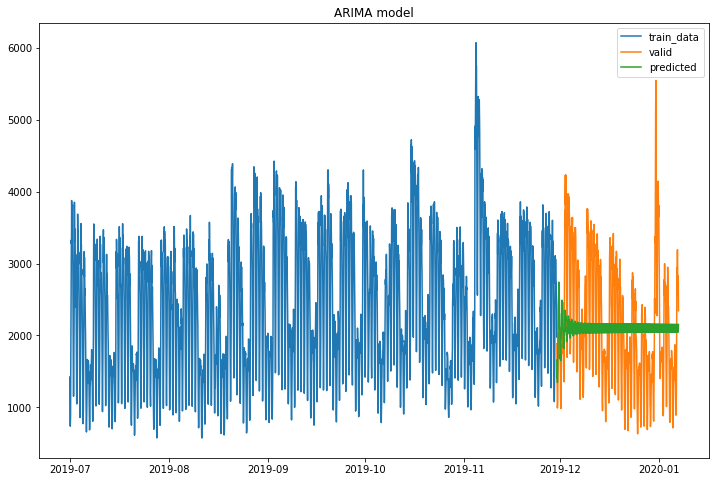

In [38]:
# fit model
model = ARIMA(train['read_count'].dropna(), order=(7,1,7))
model_fit = model.fit()

# gernerate forecasts
output = model_fit.forecast(912) 

val['ARIMA'] = (pd.DataFrame(output)).values


# plot the graph
plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['ARIMA'], label='predicted')

plt.legend(loc='best')
plt.title("ARIMA model")
plt.show()

In [39]:
np.sqrt(mse(val['read_count'],val['ARIMA']))

840.5946378334187

Auto-ARIMA:

In [ ]:
train1 = train.copy()
test1 = test.copy()


In [ ]:
# #building the model
# from pmdarima import auto_arima
# # Fit auto_arima function to AirPassengers dataset 
# stepwise_fit = auto_arima(train['read_count'], start_p = 6, start_q = 6, 
#                           max_p = 8, max_q = 8, m = 7, 
#                           start_P = 0, seasonal = True, 
#                           d = 1, 
#                           D = 1, 
#                           trace = True, 
#                           error_action ='ignore',   # we don't want to know if an order does not work 
#                           suppress_warnings = True,  # we don't want convergence warnings 
#                           stepwise = True)           # set to stepwise 
  
# # To print the summary 
# stepwise_fit.summary()



# # model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
# # model.fit(train)

# # forecast = model.predict(n_periods=len(val))
# # forecast = pd.DataFrame(forecast,index = val.index,columns=['Prediction'])

# # #plot the predictions for validation set
# # plt.plot(train, label='Train')
# # plt.plot(val, label='Valid')
# # plt.plot(forecast, label='Prediction')
# # plt.show()

SARIMA model:


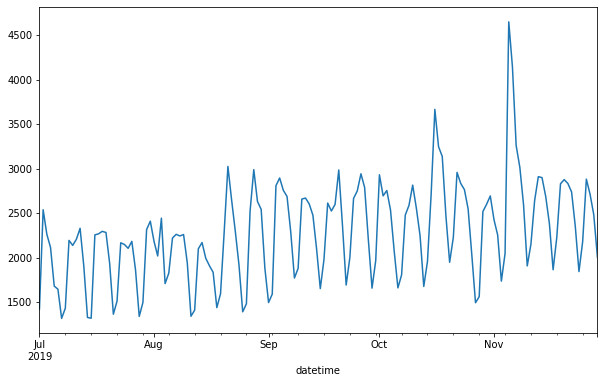

In [45]:
train['read_count'].asfreq('D').plot()

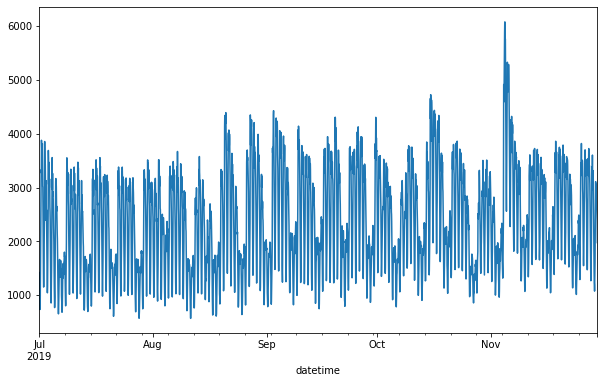

In [46]:
train['read_count'].asfreq('h').plot()

visible seasonality - week and day

In [22]:
from statsmodels.tsa.statespace import sarimax

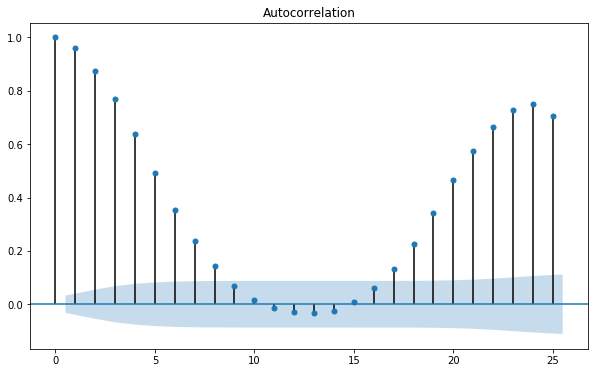

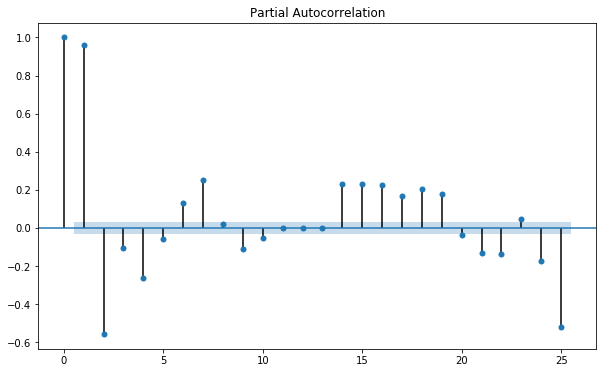

In [48]:
plot_acf(train['read_count'].dropna(), lags=25)
plot_pacf(train['read_count'].dropna(), lags=25)
plt.show()

In [17]:
#seasonal differencing

train['read_count_day']= train['read_count'] -train['read_count'].shift(1)
train['read_count_h']= train['read_count_day'] -train['read_count_day'].shift(24)

In [18]:
adf_test(train['read_count_h'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.299060e+01
p-value                        2.817837e-24
#Lags Used                     3.000000e+01
Number of Observations Used    3.592000e+03
Critical Value (1%)           -3.432172e+00
Critical Value (5%)           -2.862345e+00
Critical Value (10%)          -2.567199e+00
dtype: float64


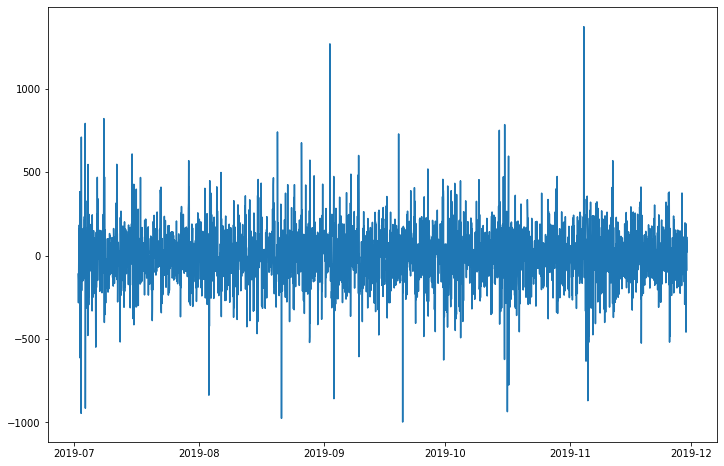

In [20]:
# plot the graph
plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count_h'], label='train_data')

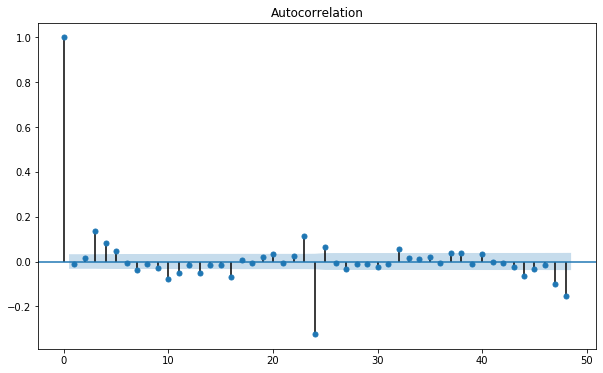

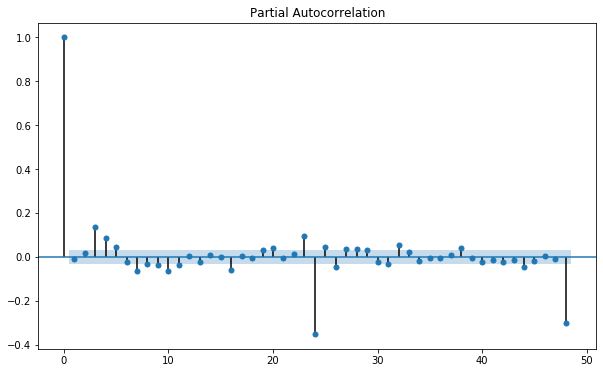

In [19]:
plot_acf(train['read_count_h'].dropna(), lags=48)
plot_pacf(train['read_count_h'].dropna(), lags=48)
plt.show()

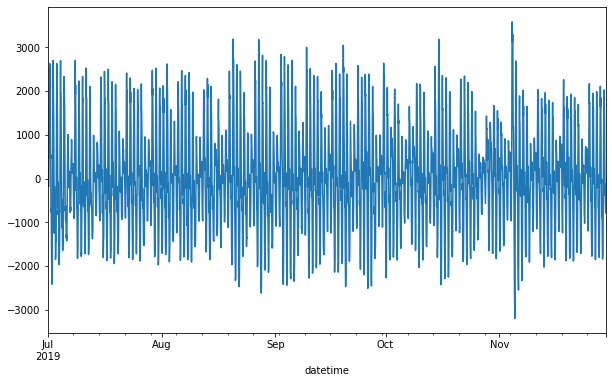

In [58]:
train['read_count_h'].asfreq('H').plot()

In [23]:
model =  sarimax.SARIMAX(train['read_count'],order = (1,1,6),seasonal_order = (1,1,1,24))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           read_count   No. Observations:                 3648
Model:             SARIMAX(1, 1, 6)x(1, 1, [1], 24)   Log Likelihood              -22793.877
Date:                              Mon, 26 Oct 2020   AIC                          45607.754
Time:                                      04:53:31   BIC                          45669.705
Sample:                                  07-01-2019   HQIC                         45629.825
                                       - 11-29-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.021     48.270      0.000       0.958       1.039
ma.L1         -0.96

In [24]:
# gernerate forecasts
output = results.forecast(912) 

val['Sarima'] = pd.DataFrame(output).values

In [25]:
test.max(),test.min()

(id                         4896
 datetime    2020-01-20 23:00:00
 dtype: object,
 id                         4561
 datetime    2020-01-07 00:00:00
 dtype: object)

In [26]:
val['Sarima']

datetime
2019-11-30 00:00:00    1695.408498
2019-11-30 01:00:00    1369.116075
2019-11-30 02:00:00    1091.873077
2019-11-30 03:00:00     839.750683
2019-11-30 04:00:00     649.757163
                          ...     
2020-01-06 19:00:00    1939.451203
2020-01-06 20:00:00    1902.657595
2020-01-06 21:00:00    1834.716801
2020-01-06 22:00:00    1731.707938
2020-01-06 23:00:00    1502.822881
Name: Sarima, Length: 912, dtype: float64

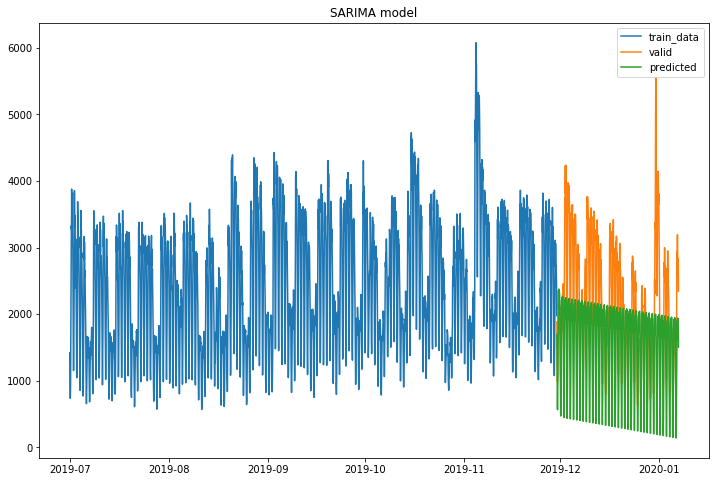

In [27]:
plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['Sarima'], label='predicted')

plt.legend(loc='best')
plt.title("SARIMA model")
plt.show()

In [28]:
np.sqrt(mse(val['read_count'],val['Sarima']))

906.8512438905859

Removing outliers

In [29]:
train1 = train.copy()
val1 = val.copy()


In [30]:
train1.loc[train1['read_count']>train1['read_count'].quantile(0.99),'read_count']=train1['read_count'].quantile(0.99)
train1.loc[train1['read_count']<train1['read_count'].quantile(0.01),'read_count']=train1['read_count'].quantile(0.01)
train1.describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
id,3648.0,1824.500000,1053.231219,1.00,37.4700,183.35,1824.5,3465.65,3611.5300,3648.00
read_count,3648.0,2324.186519,906.969976,758.94,759.4382,997.05,2208.0,3787.30,4408.7416,4414.72
read_count_day,3647.0,0.152728,264.245560,-847.00,-480.5400,-385.00,-17.0,449.40,698.0800,1452.00
read_count_h,3623.0,-0.424510,168.647318,-998.00,-428.5600,-258.90,2.0,246.90,441.8000,1372.00


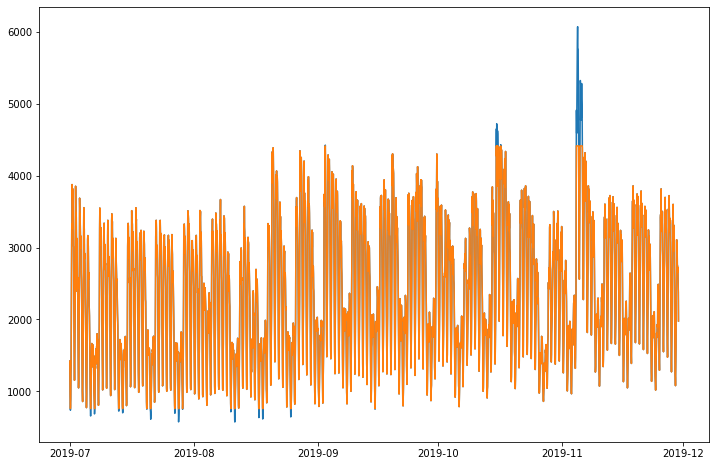

In [31]:
plt.figure(figsize=(12,8))

plt.plot(train.index, train['read_count'], label='train_data')
plt.plot(train1.index, train1['read_count'], label='train_data1')

Using new data (outliers corrected) for model building:

In [ ]:
#again running sarima model:

model =  sarimax.SARIMAX(train1['read_count'],order = (1,0,0),seasonal_order = (6,0,1,24))

# SARIMAX(train, order=(1,1,2), seasonal_order(1,1,2,7)).fit(max_iter = 50,method = 'powell')
results = model.fit()
print(results.summary())

In [ ]:
# gernerate forecasts
output = results.forecast(912) 

val['Sarima'] = pd.DataFrame(output).values

In [ ]:
test.max(),test.min()

In [ ]:
# gernerate forecasts
output1234 = results.predict(start='2020-01-07 00:00:00',end='2020-01-20 23:00:00') 

In [ ]:
submit

In [36]:
submit['total_articles_read'] = pd.DataFrame(output1234).values

In [37]:
submit.to_csv('sub1234.csv',index=False)

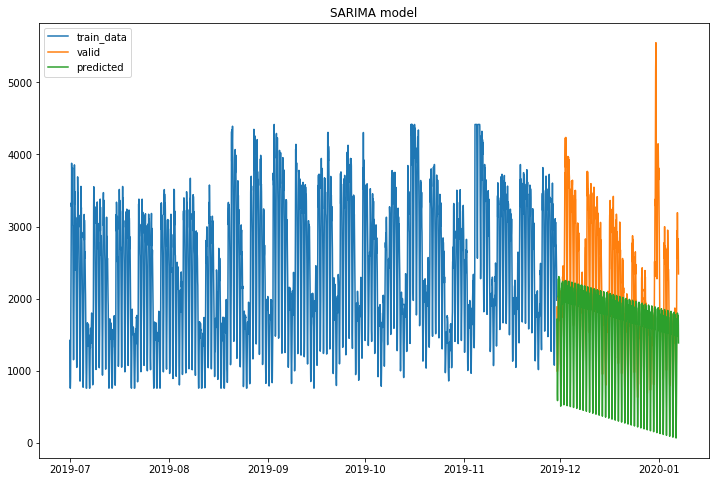

In [38]:
plt.figure(figsize=(12,8))

plt.plot(train1.index, train1['read_count'], label='train_data')
plt.plot(val.index, val['read_count'], label='valid')
plt.plot(val.index, val['Sarima'], label='predicted')

plt.legend(loc='best')
plt.title("SARIMA model")
plt.show()

In [1]:
np.sqrt(mse(val['read_count'],val['Sarima']))

cv

ValueError: 'rmse_score' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

AttributeError: module 'pandas' has no attribute 'Dataframe'